<a href="https://colab.research.google.com/github/Pini2001/retinopathy/blob/main/FIANALVGG19YALOTENGO07052023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install google-colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from zipfile import ZipFile
from PIL import Image
from skimage import data, io, color
import sys
import cv2
from cv2 import cvtColor
from skimage.feature import greycomatrix, greycoprops

In [ ]:
train_csv = '/content/drive/MyDrive/train.csv'
train_images= '/content/drive/MyDrive/train_images.zip'

In [ ]:
with ZipFile('/content/drive/MyDrive/train_images.zip', 'r') as zip_ref:
    # Loop through all files in the zip file
    for filename in zip_ref.namelist():
        # Check if the file is an image (you may want to adjust this based on your image file types)
        if filename.endswith('.png'):
            # Extract the image file to a temporary location if the directory 'DR' doesn't already exist
            if not os.path.exists('DR'):
                os.makedirs('DR')
                zip_ref.extract(filename, path='DR')
            else:
                if not os.path.exists(f'DR/{filename}'):
                    zip_ref.extract(filename, path='DR')

In [ ]:
import os
# Count the number of files in the 'DR' directory
num_images = len(os.listdir('DR'))
# Print the number of images
print(f'There are {num_images} images in the DR directory')


There are 3662 images in the DR directory


In [ ]:
train = pd.read_csv(train_csv, delimiter=',')
#Creating column 
train['labels']= np.where(train['diagnosis'] == 0, 'No', 'Si')
test = pd.read_csv(test_csv, delimiter=',')
train.dataframeName = 'train.csv'
nRow, nCol = train.shape
print(f'There are {nRow} rows and {nCol} columns in the training set')
nRow, nCol = test.shape
print(f'There are {nRow} rows and {nCol} columns  in the validation set')
#len(df.columns)
train.head()

There are 3662 rows and 3 columns in the training set
There are 1928 rows and 1 columns  in the validation set


,id_code,diagnosis,labels
0,000c1434d8d7,2,Si
1,001639a390f0,4,Si
2,0024cdab0c1e,1,Si
3,002c21358ce6,0,No
4,005b95c28852,0,No


In [ ]:
'''This Function Plots a Bar plot of output Classes Distribution'''
def plot_classes(trainvis):
    df_group = pd.DataFrame(trainvis.groupby('diagnosis').agg('size').reset_index())
    df_group.columns = ['diagnosis','frecuencia']

    sns.set(rc={'figure.figsize':(10,5)}, style = 'whitegrid')
    sns.barplot(x = 'diagnosis', y='frecuencia', data = df_group, palette = "Blues_d")
    plt.title('Niveles de severidad de la DR')
    plt.show() 

In [ ]:
plot_classes(train)

https://thedatafrog.com/en/articles/dogs-vs-cats/

https://thedatafrog.com/en/articles/image-recognition-transfer-learning/

https://www.kaggle.com/code/thanhphongl/vgg19-image-classification


In [ ]:
def resumen(model=None):
    '''
    '''
    header = '{:4} {:16} {:24} {:24} {:10}'.format('#', 'Layer Name','Layer Input Shape','Layer Output Shape','Parameters'
    )
    print('='*(len(header)))
    print(header)
    print('='*(len(header)))
    count=0
    count_trainable=0
    for i, layer in enumerate(model.layers):
        count_trainable += layer.count_params() if layer.trainable else 0
        input_shape = '{}'.format(layer.input_shape)
        output_shape = '{}'.format(layer.output_shape)
        str = '{:<4d} {:16} {:24} {:24} {:10}'.format(i,layer.name, input_shape, output_shape, layer.count_params())
        print(str)
        count += layer.count_params()
    print('_'*(len(header)))
    print('Total Parameters : ', count)
    print('Total Trainable Parameters : ', count_trainable)
    print('Total No-Trainable Parameters : ', count-count_trainable)
    
  
vgg19=None


Importar las bibliotecas necesarias:

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.vgg19 import VGG19
import matplotlib.pyplot as plt

In [ ]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg19 import preprocess_input

def generators(shape, preprocessing, train_csv): 
    train_datagen = ImageDataGenerator(
        preprocessing_function=preprocessing,
        horizontal_flip=True,
        validation_split=0.25
    )

    # Load the CSV file with image filenames and their corresponding labels
    df = pd.read_csv(train_csv)
    df['id_code'] = df['id_code'].apply(lambda x: x + '.png')
    df['label'] = np.where(df['diagnosis'] == 0, 'No', 'Si')

    # Create the data generators
    train_generator = train_datagen.flow_from_dataframe(
        dataframe=df,
        directory='/content/DR',
        x_col='id_code',
        y_col='label',
        target_size=(224, 224),
        batch_size=30,
        class_mode='binary',
        subset='training'
    )

    val_generator = train_datagen.flow_from_dataframe(
        dataframe=df,
        directory='/content/DR',
        x_col='id_code',
        y_col='label',
        target_size=(224, 224),
        batch_size=30,
        class_mode='binary',
        subset='validation'
    )

    return train_generator, val_generator


In [ ]:
train_generator, val_generator = generators((224, 224), preprocess_input, train_csv)

# Print the number of images in the train and validation generators
print(f'There are {train_generator.n} images in the training generator')
print(f'There are {val_generator.n} images in the validation generator')


Found 2747 validated image filenames belonging to 2 classes.
Found 915 validated image filenames belonging to 2 classes.
There are 2747 images in the training generator
There are 915 images in the validation generator


In [ ]:
x_train, y_train = next(train_generator)
x_val, y_val = next(val_generator)
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)


(30, 224, 224, 3) (30,)
(30, 224, 224, 3) (30,)


In [ ]:
#train_datagen = ImageDataGenerator(rescale=1./255) # no se aplica aumento de datos 
#train_generator = train_datagen.flow_from_directory( 'ruta/a/las/imagenes',    target_size=(224, 224),   batch_size=30,   class_mode='binary')
#def generators(shape, preprocessing): 
#train_datagen = ImageDataGenerator(preprocessing_function = preprocessing, rescale = 1/255.,  horizontal_flip = True, validation_split = 0.25)
#train_dataset = train_datagen.flow_from_directory(os.getcwd('/content/DR'), target_size=(224, 224), classes = ('Si','No'), batch_size = 30,  subset = 'training' )
#val_dataset = train_datagen.flow_from_directory( os.getcwd('/content/DR'),  target_size = (224, 224) , classes = ('Si','No'), batch_size = 30, subset = 'validation')


In [ ]:
base_model = VGG19(weights='imagenet', include_top=False, input_shape = (224,224, 3))
print('VGG19 Descargado')
resumen(base_model)


VGG19 Descargado
#    Layer Name       Layer Input Shape        Layer Output Shape       Parameters
0    input_1          [(None, 224, 224, 3)]    [(None, 224, 224, 3)]             0
1    block1_conv1     (None, 224, 224, 3)      (None, 224, 224, 64)           1792
2    block1_conv2     (None, 224, 224, 64)     (None, 224, 224, 64)          36928
3    block1_pool      (None, 224, 224, 64)     (None, 112, 112, 64)              0
4    block2_conv1     (None, 112, 112, 64)     (None, 112, 112, 128)         73856
5    block2_conv2     (None, 112, 112, 128)    (None, 112, 112, 128)        147584
6    block2_pool      (None, 112, 112, 128)    (None, 56, 56, 128)               0
7    block3_conv1     (None, 56, 56, 128)      (None, 56, 56, 256)          295168
8    block3_conv2     (None, 56, 56, 256)      (None, 56, 56, 256)          590080
9    block3_conv3     (None, 56, 56, 256)      (None, 56, 56, 256)          590080
10   block3_conv4     (None, 56, 56, 256)      (None, 56, 56, 256)    

Cargar el modelo pre-entrenado VGG19 con los pesos de ImageNet y sin la última capa densa:

Congelar las capas convolucionales del modelo base:

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

Añadir una nueva capa densa en la parte superior del modelo base para nuestra tarea de clasificación binaria

In [ ]:
x = base_model.output
x = GlobalAveragePooling2D()(x)  
#GlobalAveragePooling2D() tends to work better for tasks where the spatial location of the features is not as important
#such as image classificationas it allows the model to focus more on the global patterns in the image.
# Flatten() can be more suitable for tasks where the spatial location of the features is important, such as object detection, as it preserves the spatial information in the output.
# one hidden layers
x = Dense(100, activation='relu')(x) # small dataset it is generally advisable to start with a smaller number of neurons in the intermediate layer to avoid overfitting
#x = Dense(128, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)  # for binary classification between patients with diabetic retinopathy or not.



Crear el modelo final especificando las entradas y salidas:

In [ ]:
# creating the full model:
model = Model(inputs=base_model.input, outputs=predictions)
resumen(model)

#    Layer Name       Layer Input Shape        Layer Output Shape       Parameters
0    input_1          [(None, 224, 224, 3)]    [(None, 224, 224, 3)]             0
1    block1_conv1     (None, 224, 224, 3)      (None, 224, 224, 64)           1792
2    block1_conv2     (None, 224, 224, 64)     (None, 224, 224, 64)          36928
3    block1_pool      (None, 224, 224, 64)     (None, 112, 112, 64)              0
4    block2_conv1     (None, 112, 112, 64)     (None, 112, 112, 128)         73856
5    block2_conv2     (None, 112, 112, 128)    (None, 112, 112, 128)        147584
6    block2_pool      (None, 112, 112, 128)    (None, 56, 56, 128)               0
7    block3_conv1     (None, 56, 56, 128)      (None, 56, 56, 256)          295168
8    block3_conv2     (None, 56, 56, 256)      (None, 56, 56, 256)          590080
9    block3_conv3     (None, 56, 56, 256)      (None, 56, 56, 256)          590080
10   block3_conv4     (None, 56, 56, 256)      (None, 56, 56, 256)          590080
11  

Compilar el modelo especificando la función de pérdida, el optimizador y la métrica:

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=0.001),
              metrics=['accuracy'])


In [ ]:

def plot_history(history, yrange):
    '''Plot loss and accuracy as a function of the epoch,
    for the training and validation datasets.
    '''
    acc = history.history['accuracy'] #['acc'] 
    #acc = history.history['acc'] 
    val_acc = history.history['val_accuracy']
    #val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Get number of epochs
    epochs = range(len(acc))

    # Plot training and validation accuracy per epoch
    plt.plot(epochs, acc)
    plt.plot(epochs, val_acc)
    plt.title('Training and validation accuracy')
    plt.ylim(yrange)
    
    # Plot training and validation loss per epoch
    plt.figure()

    plt.plot(epochs, loss)
    plt.plot(epochs, val_loss)
    plt.title('Training and validation loss')
    
    plt.show()


In [ ]:
#model.fit(train_generator, steps_per_epoch=train_steps, epochs=num_epochs,  validation_data=val_generator, validation_steps=val_steps)
#model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_val, y_val))
#history = model.fit_generator(train_generator,val_generator, workers=10,epochs= 10)
#plot_history(history, yrange=(0.9,1))


Entrenar el modelo con nuestros datos:

Tarda mucho

<ipython-input-27-86f41c4f8254>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, epochs=5, validation_data=val_generator, workers=10)


Epoch 1/5
92/92 [==============================] - 3418s 37s/step - loss: 0.2245 - accuracy: 0.9159 - val_loss: 0.1703 - val_accuracy: 0.9290
Epoch 2/5
92/92 [==============================] - 3409s 37s/step - loss: 0.1201 - accuracy: 0.9574 - val_loss: 0.1347 - val_accuracy: 0.9585
Epoch 3/5
92/92 [==============================] - 3412s 37s/step - loss: 0.1175 - accuracy: 0.9603 - val_loss: 0.1179 - val_accuracy: 0.9563
Epoch 4/5
92/92 [==============================] - 3409s 37s/step - loss: 0.0948 - accuracy: 0.9680 - val_loss: 0.1253 - val_accuracy: 0.9574
Epoch 5/5
92/92 [==============================] - 3455s 37s/step - loss: 0.1014 - accuracy: 0.9651 - val_loss: 0.0951 - val_accuracy: 0.9661


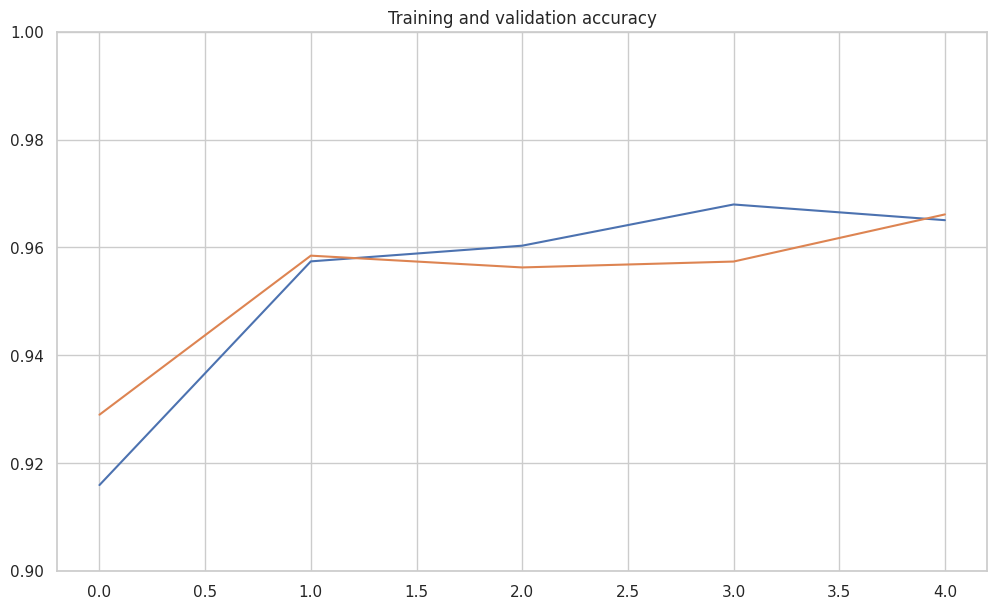

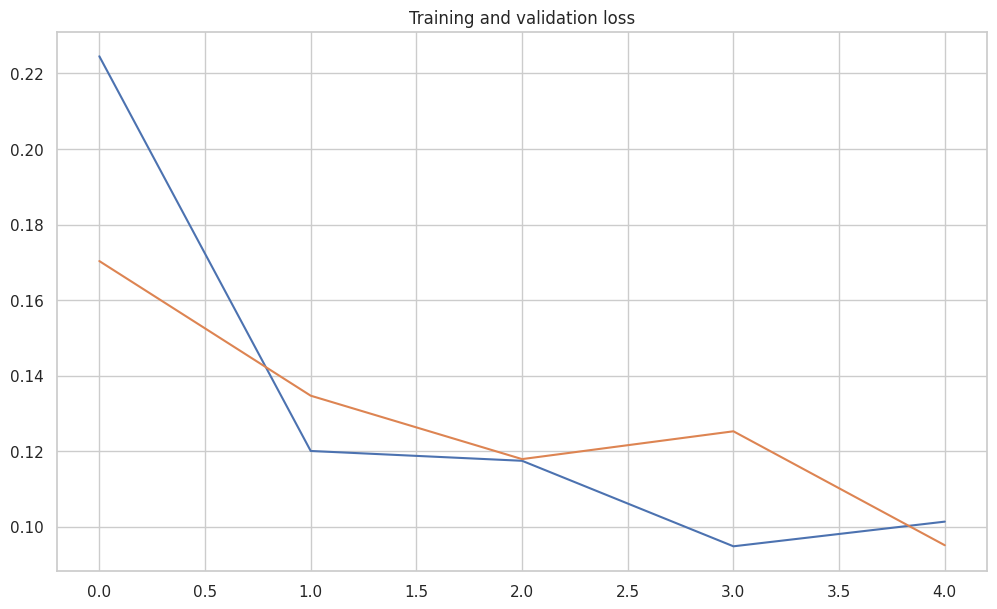

In [ ]:
history = model.fit_generator(train_generator, epochs=5, validation_data=val_generator, workers=10) 
plot_history(history, yrange=(0.9,1))


In [ ]:
#history = model.fit_generator(train_generator, epochs=10, validation_data=val_generator)
#history = model.fit_generator(train_generator, epochs=1, validation_data=val_generator, workers=10)

In [ ]:
#plot_history(history, yrange=(0.9,1))

In [ ]:
#history = model.fit_generator(train_generator, epochs=5, validation_data=val_generator, workers=10)

FIN

en principio funciona todo, lo único que no he conseguido q se me carge la linea del histori en 1h30, tendré q runear el código con tiempo mañana 